# Analyse des Composantes Principales

D'après les conclusions de l'analyse exploiration des données (2_EDA_Amazing.ipynb) section précédentes
Les variables numériques retenues qui semblent les plus pertinentes pour réaliser une ACP

`total_purchase_value` : Indique la valeur totale des achats, ce qui est crucial pour comprendre la valeur monétaire des segments.
`number_of_sessions_7m` ou `number_of_views_7m` : Mesure la fréquence d'utilisation, un indicateur de l'engagement utilisateur.
`days_since_last_purchase`: Donne une idée de la rétention ou de l'inactivité, essentiel pour évaluer la fidélité.


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np




# Lire le fichier Parquet
df = pd.read_parquet("data/user_stats_df_output.parquet")


In [19]:


# Calcul du nombre total d'achats en utilisant la valeur totale des achats divisée par le prix moyen sur 7 mois
df['total_purchases'] = df['total_purchase_value'] / df['avg_price_7m']
df['total_purchases'] = df['total_purchases'].fillna(0).astype(int)  # Conversion en entier et gestion des NaN


In [20]:
df.columns

Index(['user_id', 'number_of_views_2m', 'number_of_carts_2m',
       'number_of_sessions_2m', 'count_products_2m', 'avg_price_2m',
       'number_of_views_5m', 'number_of_carts_5m', 'number_of_sessions_5m',
       'count_products_5m', 'avg_price_5m', 'number_of_views_7m',
       'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
       'avg_price_7m', 'last_purchase', 'days_since_last_purchase',
       'total_purchase_value', 'cart_abandonments', 'preferred_brand',
       'preferred_category', 'most_active_time', 'most_active_day',
       'total_purchases'],
      dtype='object')

In [21]:
# Calcul de la valeur moyenne d'achat, évite la division par zéro en utilisant np.where
df['avg_purchase_value'] = np.where(df['total_purchases'] > 0, df['total_purchase_value'] / df['total_purchases'], 0)


In [22]:
# Calcul du taux de conversion en pourcentage
df['conversion_rate'] = np.where(df['number_of_carts_7m'] > 0, df['total_purchases'] / df['number_of_carts_7m'], 0)

In [23]:
# Supposons une période d'observation de 30 jours (1 mois environ)
observation_period_days = 30
df['purchase_frequency'] = df['total_purchases'] / observation_period_days

In [24]:
# Calcul d'un score de fidélité simplifié
df['loyalty_score'] = (df['purchase_frequency'] * 0.5) + (df['avg_purchase_value'] * 0.3) - (df['days_since_last_purchase'] * 0.2)


In [25]:
df.columns

Index(['user_id', 'number_of_views_2m', 'number_of_carts_2m',
       'number_of_sessions_2m', 'count_products_2m', 'avg_price_2m',
       'number_of_views_5m', 'number_of_carts_5m', 'number_of_sessions_5m',
       'count_products_5m', 'avg_price_5m', 'number_of_views_7m',
       'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
       'avg_price_7m', 'last_purchase', 'days_since_last_purchase',
       'total_purchase_value', 'cart_abandonments', 'preferred_brand',
       'preferred_category', 'most_active_time', 'most_active_day',
       'total_purchases', 'avg_purchase_value', 'conversion_rate',
       'purchase_frequency', 'loyalty_score'],
      dtype='object')

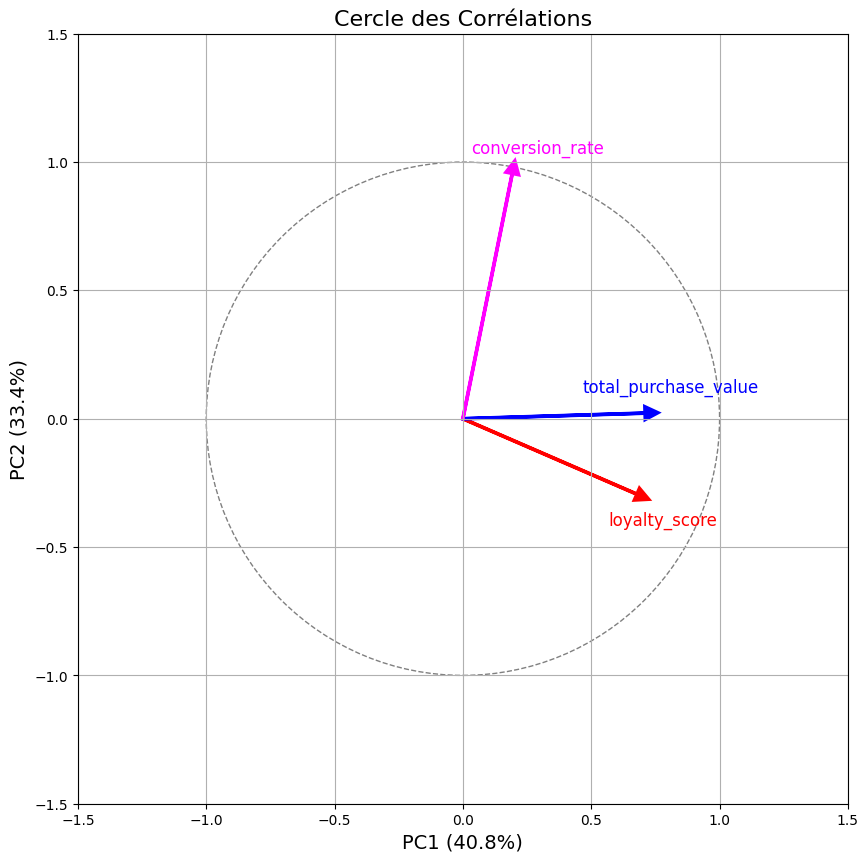

Variance expliquée par PC1: 40.81%
Variance expliquée par PC2: 33.45%


In [26]:

# Sélection des colonnes pour l'ACP
variables_acp = [
    # 'total_purchase_value', 'number_of_sessions_7m', 'count_products_7m',
    # 'number_of_carts_7m', 'total_purchases', 'avg_purchase_value',
    # 'conversion_rate', 'purchase_frequency', 'loyalty_score'
    'loyalty_score','total_purchase_value',
    'conversion_rate'
]

# Vérifiez que toutes les colonnes sélectionnées sont bien présentes
missing_columns = [col for col in variables_acp if col not in df.columns]
if missing_columns:
    print(f"Colonnes manquantes : {missing_columns}")
else:
    # Extraction des données pour les variables sélectionnées
    X = df[variables_acp]

    # Standardisation des données
    X_standardized = StandardScaler().fit_transform(X)

    # Réalisation de l'ACP
    pca = PCA(n_components=2)  # Nous prenons 2 composantes principales pour la visualisation
    principal_components = pca.fit_transform(X_standardized)

    # Fonction pour afficher le cercle des corrélations
    def plot_correlation_circle(pca, components, features, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10))

        # Dessin du cercle
        circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
        ax.add_artist(circle)

        # Couleurs distinctes pour chaque flèche
        colors = ['red', 'blue', 'magenta', 'orange', 'brown', 'green', 'purple', 'cyan', 'black']

        # Boucle pour afficher les vecteurs et labels
        for i in range(len(features)):
            ax.arrow(0, 0, components[i, 0], components[i, 1], 
                     head_width=0.05, head_length=0.05, linewidth=2.5, color=colors[i % len(colors)])
            
            # Positionnement conditionnel des labels pour éviter les chevauchements
            offset_x = 0.1 if components[i, 0] > 0 else -0.1
            offset_y = 0.1 if components[i, 1] > 0 else -0.1
            
            ax.text(components[i, 0] + offset_x, components[i, 1] + offset_y, 
                    features[i], ha='center', va='center', fontsize=12, color=colors[i % len(colors)])

        ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=14)
        ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=14)
        ax.set_title('Cercle des Corrélations', fontsize=16)
        ax.grid(True)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')

    # Calcul des composantes principales
    components = pca.components_.T

    # Affichage du cercle de corrélation
    plot_correlation_circle(pca, components, variables_acp)
    plt.show()

    # Afficher l'explication des composantes principales
    explained_variance = pca.explained_variance_ratio_
    print(f"Variance expliquée par PC1: {explained_variance[0]:.2%}")
    print(f"Variance expliquée par PC2: {explained_variance[1]:.2%}")



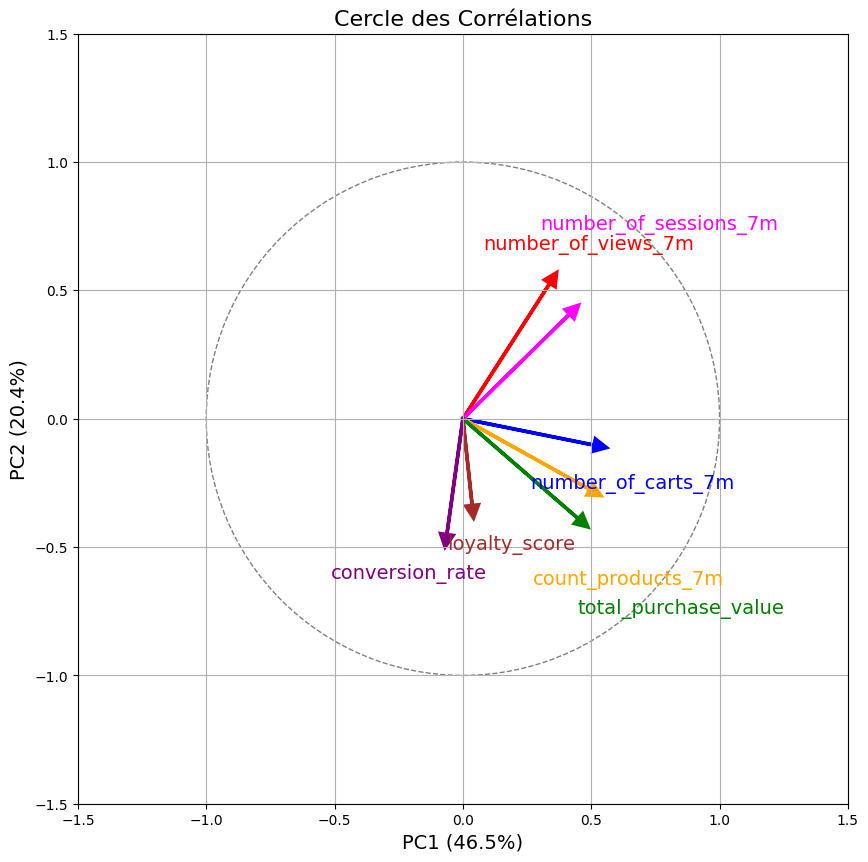

Variance expliquée par PC1: 46.51%
Variance expliquée par PC2: 20.44%


In [27]:

# # Lecture du fichier parquet
# df = pd.read_parquet("data/user_stats_df_output.parquet")

# # Vérification des colonnes disponibles dans le DataFrame
# print(df.columns)

# Sélection des colonnes pertinentes pour l'ACP
# Suppression de 'total_purchases' car elle n'est pas présente
# variables_acp = [
#     # 'total_purchase_value', 'number_of_views_7m',
#     # 'count_products_7m', 'number_of_carts_7m'
#     'number_of_views_7m',
#     'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
#     'days_since_last_purchase','total_purchase_value', 'cart_abandonments'
# ]


# Sélection des variables pour l'ACP
variables_acp = [
    'number_of_views_7m',
    'number_of_carts_7m', 'number_of_sessions_7m', 'count_products_7m',
    'loyalty_score', 'total_purchase_value',
    'conversion_rate'
]

# Extraction des données pour les variables sélectionnées
X = df[variables_acp]

# Standardisation des données
X_standardized = StandardScaler().fit_transform(X)

# Réalisation de l'ACP
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)

# Fonction pour afficher le cercle des corrélations avec un ajustement des labels
def plot_correlation_circle(pca, components, features, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    # Dessin du cercle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
    ax.add_artist(circle)

    # Couleurs pour les flèches (ajusté le nombre de couleurs)
    colors = ['red', 'blue', 'magenta', 'orange', 'brown', 'green', 'purple'] 

    # Boucle pour afficher les vecteurs et labels
    for i in range(len(features)):
        ax.arrow(0, 0, components[i, 0], components[i, 1], 
                 head_width=0.05, head_length=0.05, linewidth=2.5, color=colors[i])
        
        # Positionnement conditionnel des labels pour éviter les chevauchements
        offset_x = 0.15 if components[i, 0] > 0 else -0.15
        offset_y = 0.15 if components[i, 1] > 0 else -0.15

        # Ajustement spécifique pour les étiquettes problématiques
        if features[i] == 'count_products_7m':
            offset_y -= 0.2
        elif features[i] == 'total_purchase_value':
            offset_x += 0.25
            offset_y -= 0.2
        elif features[i] == 'number_of_sessions_7m':
            offset_x += 0.2
            offset_y += 0.2
        
        ax.text(components[i, 0] + offset_x, components[i, 1] + offset_y, 
                features[i], ha='center', va='center', fontsize=14, color=colors[i])

    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=14)
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=14)
    ax.set_title('Cercle des Corrélations', fontsize=16)
    ax.grid(True)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')

# Calcul des composantes principales
components = pca.components_.T

# Affichage du cercle de corrélation
plot_correlation_circle(pca, components, variables_acp)
plt.show()

# Affichage de la variance expliquée par les deux premières composantes
explained_variance = pca.explained_variance_ratio_
if len(explained_variance) >= 2:
    print(f"Variance expliquée par PC1: {explained_variance[0]:.2%}")
    print(f"Variance expliquée par PC2: {explained_variance[1]:.2%}")
else:
    print("La variance expliquée par les composantes principales n'est pas suffisante.")



Les variables contribuent le plus à expliquer la variance dans les données. Voici les variables les plus influentes, d'après le cercle des corrélations.

1. **`number_of_views_7m` et `number_of_sessions_7m`** (flèches rouge et magenta) :
   - Ces variables sont alignées le long de la composante PC1, ce qui indique qu'elles ont une contribution significative pour expliquer cette composante principale. Elles sont liées aux comportements d'engagement des utilisateurs sur la plateforme.

2. **`total_purchase_value`** (flèche verte) :
   - Positionnée principalement sur PC1, cette variable est essentielle pour comprendre les comportements d'achat des clients. Elle indique que la valeur totale des achats est une dimension clé.

3. **`loyalty_score` et `conversion_rate`** (flèches marron et violet) :
   - Bien que moins étendues, ces flèches indiquent des contributions importantes, surtout en corrélation avec PC2. Elles sont pertinentes pour capturer la fidélité des clients et l'efficacité de leurs interactions sur le site.

4. **`number_of_carts_7m` et `count_products_7m`** (flèches bleu et orange) :
   - Ces variables ont une contribution modérée mais restent proches des axes principaux, ce qui indique leur pertinence pour l'analyse des comportements liés aux ajouts au panier et à la consultation de produits.

### Variables à Retenir :
- **`number_of_views_7m`**
- **`number_of_sessions_7m`**
- **`total_purchase_value`**
- **`loyalty_score`**
- **`conversion_rate`**

Ces variables capturent les principales dimensions des comportements d'engagement, d'achat, et de fidélité des clients, et sont donc essentielles pour une analyse plus approfondie.

Ce choix de  moins de variables (4) permet d'obtenir une très bonne représentation (92.2%) des comportements clés (vues, ajouts au panier, achats). Les variables choisies sont directement liées aux actions concrètes des utilisateurs sur la plateforme, rendant l'analyse plus claire et centrée.

Inertia : 233480.89274771704
Silhouette Score : 0.39


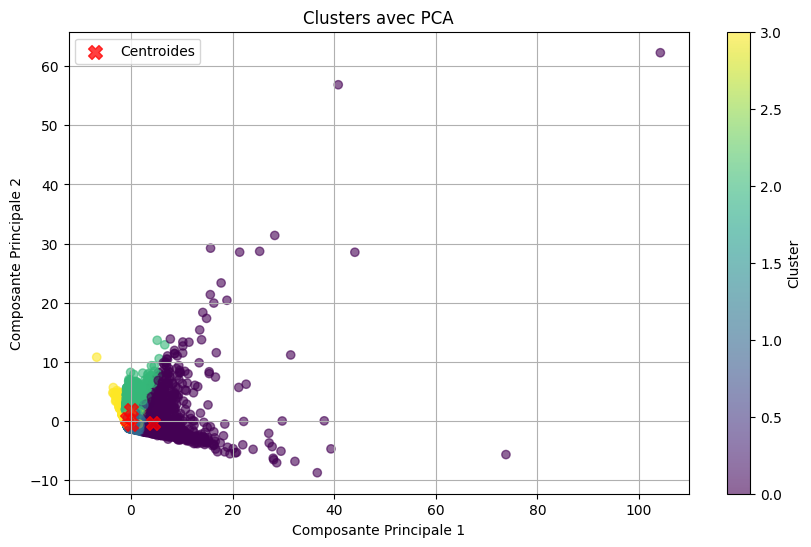

In [28]:



# Sélection des variables pertinentes pour le clustering
variables_pour_clustering = [
    'number_of_views_7m',
    'number_of_sessions_7m',
    'loyalty_score','total_purchase_value',
    'conversion_rate'
]

# Filtrage et normalisation des données
X = df[variables_pour_clustering].dropna()
X_scaled = StandardScaler().fit_transform(X)

# Application du K-means avec le nombre optimal de clusters (par exemple 4)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# Calcul et affichage de l'Inertie et du Silhouette Score
print(f"Inertia : {kmeans.inertia_}")
print(f"Silhouette Score : {silhouette_score(X_scaled, clusters):.2f}")

# Visualisation des clusters avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Transformation des centroïdes avec la même PCA utilisée sur les données
centroids = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)

# Ajout des centroïdes correctement placés
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, alpha=0.75, marker='X', label='Centroides')

plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Clusters avec PCA')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True)
plt.show()



## Interprétation des Relations entre les Variables

Ensemble, PC1 et PC2 expliquent environ 55.4% de la variance totale des données, ce qui signifie que ces deux axes capturent une grande partie de l'information contenue dans les variables d'origine.


`number_of_sessions_7m et total_purchase_value` :

Ces deux variables sont **assez proches**, ce qui suggère qu'elles sont positivement corrélées. Cela signifie que les clients qui ont un nombre élevé de sessions tendent également à avoir une valeur totale d'achat élevée.

`avg_price_7m` :

Cette variable est orientée dans une direction distincte, mais est relativement proche de total_purchase_value, ce qui pourrait indiquer une certaine corrélation positive avec la valeur totale des achats, bien que moins forte que number_of_sessions_7m.

`brand_loyalty` :

Cette variable est orientée presque à l'opposé des autres variables, surtout par rapport à number_of_sessions_7m et total_purchase_value, ce qui suggère une corrélation négative. Cela pourrait indiquer que **les utilisateurs plus fidèles à une marque ne sont pas nécessairement ceux qui effectuent le plus d'achats ou qui ont le plus de sessions**.

`days_since_last_purchase` :

Cette variable est orientée vers le centre, ce qui indique qu'elle n'est pas fortement corrélée avec les autres variables dans cet espace. Cela suggère que **le temps écoulé depuis le dernier achat est une mesure indépendante de l'engagement utilisateur ou des habitudes d'achat**.


**Conclusion :**

Le cercle de corrélation montre clairement quelles variables sont les plus corrélées et comment elles se comportent par rapport aux composantes principales. Cela vous aide à comprendre la structure sous-jacente des données et à identifier les variables les plus influentes dans l'analyse (`number_of_sessions_7m`, `avg_price_7m`, `total_purchase_value`)

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 



Étant donné que `brand_loyalty` et `days_since_last_purchase` sont moins bien représentées dans l'ACP, nous pouvons  les exclure du reste de l'analyse de manière à nous concentrer sur les dimensions principales du comportement utilisateur. Ces variables semblent ne pas apporter beaucoup d'information supplémentaire dans des modèles qui cherchent à expliquer les comportements ou à segmenter les utilisateurs.
</div>

In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Supposons que df soit votre DataFrame contenant les données e-Amazing
# Sélection des variables pertinentes pour le clustering
# variables_pour_clustering = [
#    # 'number_of_views_7m',
#    # 'number_of_carts_7m',
#    # 'number_of_sessions_7m',
#     # 'avg_price_7m',
#     # 'total_purchase_value',
#    # 'days_since_last_purchase',
#    # 'cart_abandonments',
#     'total_purchase_value', 
#     'number_of_views_7m',
#     #'count_products_7m', 
#     #'number_of_carts_7m',  
#     'number_of_sessions_7m' 
#    #'avg_session_duration'
# ]
variables_pour_clustering = [
    'number_of_sessions_7m',
    'loyalty_score',
    'total_purchase_value',
    'conversion_rate'
]

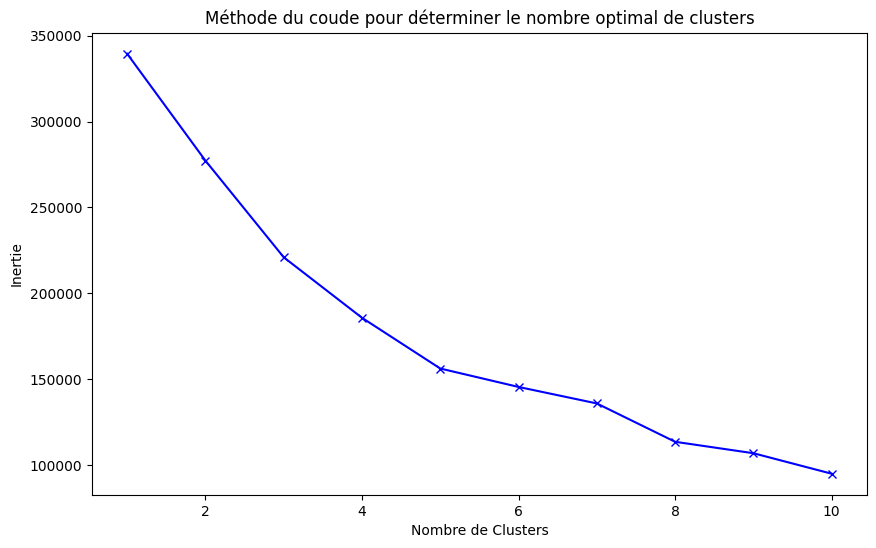

In [34]:

# Filtrer le DataFrame pour ne garder que ces variables
X = df[variables_pour_clustering]

# Suppression des lignes avec des valeurs manquantes
X = X.dropna()

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Détermination du nombre optimal de clusters avec la méthode du coude (Elbow Method)
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()

D'après le graphique de la méthode du coude **(Elbow Method)**, le nombre optimal de clusters est déterminé au point où l'inertie commence à diminuer de manière moins significative, indiquant une amélioration significative de la qualité du regroupement (formant un coude dans la courbe).  Ici, le coude semble se situer autour de 4 clusters.

La réduction de l'inertie devient plus faible à chaque ajout de cluster supplémentaire, suggérant que les gains supplémentaires ne justifient pas l'augmentation de la complexité du modèle.

**D'où, le choix optimal semble être de  4 clusters pour paramétrer le K-means, car il représente un bon compromis entre complexité et efficacité du modèle.**

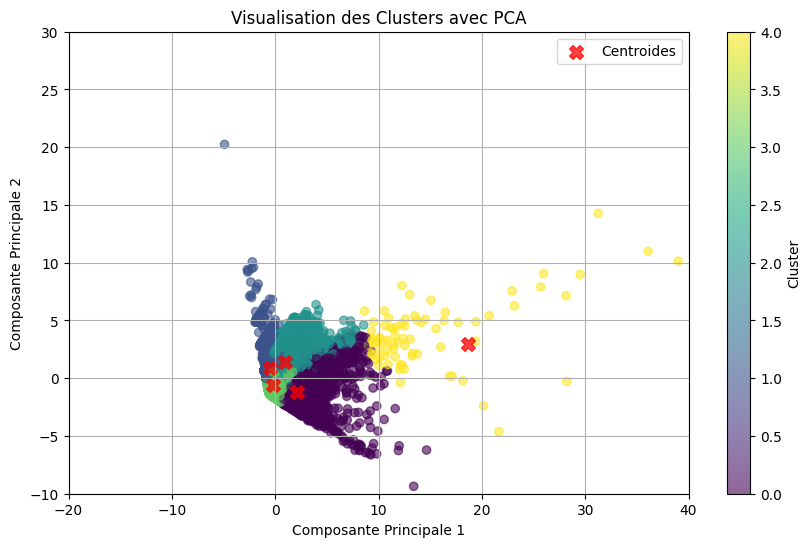

Silhouette Score : 0.43


In [35]:
# Choix du nombre de clusters 
k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Ajout des clusters au DataFrame original
df['Cluster'] = clusters



# Calcul et affichage du Silhouette Score
silhouette_avg = silhouette_score(X_scaled, clusters)


# Visualisation des clusters avec PCA (Réduction de dimension pour la visualisation)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)

# Ajout des centroïdes des clusters avec taille réduite
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, alpha=0.75, marker='X', label='Centroides')

plt.title('Visualisation des Clusters avec PCA')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.xlim(-20, 40)  # Ajustement des limites des axes pour ignorer les outliers extrêmes
plt.ylim(-10, 30)
plt.grid(True)
plt.show()
print(f"Silhouette Score : {silhouette_avg:.2f}")


In [32]:
df['Cluster']

0        1
1        0
2        3
3        3
4        1
        ..
84859    1
84860    3
84861    3
84862    3
84863    1
Name: Cluster, Length: 84864, dtype: int32

### 1. Examiner les composantes principales et leurs contributions :

In [36]:
print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)


Variance expliquée par chaque composante : [0.35161461 0.27952897]


- Composante principale 1 (CP1) : 35,16% de la variance est expliquée par cette composante.

- Composante principale 2 (CP2) : 27,95% de la variance est expliquée par cette composante.

Ainsi, ces deux composantes capturent ensemble environ **63,11%** de la variance des données. Cela signifie que les deux premières composantes principales sont assez représentatives des différences entre les utilisateurs, mais il reste 36,89% de la variance qui n'est pas expliquée par ces deux dimensions.

### 2. Analyser les coefficients des composantes principales :

In [37]:
pca_components = pd.DataFrame(pca.components_, columns=variables_pour_clustering)
print(pca_components)


   number_of_sessions_7m  loyalty_score  total_purchase_value  conversion_rate
0               0.635513       0.310259              0.688609        -0.160249
1              -0.386990       0.564203              0.261393         0.680872


### 3. Interpréter les clusters sur les deux premières composantes principales :


    - Composante principale 1 (CP1) :

Les variables qui ont la plus grande influence positive sur cette composante sont total_purchase_value (0.688) et number_of_sessions_7m (0.636). Cela suggère que la CP1 est fortement liée à l'engagement des utilisateurs et à la valeur totale des achats.
Les utilisateurs avec des scores élevés sur la CP1 sont donc des utilisateurs avec **beaucoup de sessions et une valeur totale d'achat élevée**.

    - Composante principale 2 (CP2) :

Les variables dominantes dans la CP2 sont conversion_rate (0.681) et loyalty_score (0.564). La CP2 semble donc capturer les aspects liés à la fidélité et au taux de conversion.
Les utilisateurs avec des scores élevés sur la CP2 sont ceux qui ont **un taux de conversion élevé et un score de fidélité élevé**.

### 4. Calculer les moyennes des variables par cluster :


In [38]:
cluster_means = df.groupby('Cluster')[variables_pour_clustering].mean()
print(cluster_means)


         number_of_sessions_7m  loyalty_score  total_purchase_value  \
Cluster                                                               
0                   104.705598      66.097296           4338.160204   
1                     9.203715      58.580636            821.745567   
2                    14.415565     296.801620           3426.090670   
3                    16.442886      54.052630            533.145687   
4                   293.261905     194.197214          92787.338810   

         conversion_rate  
Cluster                   
0               0.377852  
1               0.939509  
2               0.497749  
3               0.341738  
4               0.720125  





#### **Cluster 0 :**  Fourmi 🐜  → Beaucoup de sessions, mais conversion et valeur d'achat modérées.
- **Nombre de sessions moyen** : 104.7 (relativement élevé)
- **Score de fidélité** : 66.1 (modéré)
- **Valeur totale des achats** : 4338.16 (modérée)
- **Taux de conversion** : 0.377 (plutôt faible)

Ce groupe pourrait représenter des **"Clients Actifs Modérés"**. Ils ont un nombre de sessions élevé, mais leur taux de conversion est relativement bas. Leur valeur totale d'achat est modérée, ce qui indique qu'ils sont actifs mais ne convertissent pas autant que les autres.

#### **Cluster 1 :**  Faucon 🦅 → Peu de sessions, conversion très élevée.
- **Nombre de sessions moyen** : 9.2 (très faible)
- **Score de fidélité** : 58.6 (faible)
- **Valeur totale des achats** : 821.7 (très faible)
- **Taux de conversion** : 0.939 (élevé)

Ce groupe pourrait être appelé les **"Acheteurs Rapides"**. Bien qu'ils aient un faible nombre de sessions et une faible fidélité, leur taux de conversion est très élevé, ce qui signifie qu'ils sont efficaces pour convertir leurs visites en achats, mais ne reviennent pas souvent.

#### **Cluster 2 :**  Castor 🦫  → Score de fidélité très élevé, mais sessions et dépenses modérées.
- **Nombre de sessions moyen** : 14.4 (faible)
- **Score de fidélité** : 296.8 (très élevé)
- **Valeur totale des achats** : 3426.1 (modérée)
- **Taux de conversion** : 0.497 (moyen)

Ce groupe pourrait représenter des **"Clients Fidèles Modérés"**. Ils ont un score de fidélité très élevé, bien qu'ils aient un faible nombre de sessions et une valeur totale des achats modérée. Leur taux de conversion est également moyen, ce qui indique qu'ils reviennent souvent mais ne dépensent pas énormément.

#### **Cluster 3 :**  Chenille 🐛  → Faible activité, faible engagement et faible conversion
- **Nombre de sessions moyen** : 16.4 (faible)
- **Score de fidélité** : 54.1 (faible)
- **Valeur totale des achats** : 533.1 (très faible)
- **Taux de conversion** : 0.341 (faible)

Ce groupe pourrait être qualifié d'**"Explorateurs Passifs"**. Ils ont un faible nombre de sessions, une faible fidélité et une faible valeur d'achat. Leur taux de conversion est également bas, ce qui signifie qu'ils visitent le site mais ne sont pas enclins à acheter.

#### **Cluster 4 :**  Lion 🦁 → Utilisateurs très engagés avec un score de fidélité, un nombre de sessions, et une valeur d'achat très élevés.
- **Nombre de sessions moyen** : 293.3 (très élevé)
- **Score de fidélité** : 194.2 (très élevé)
- **Valeur totale des achats** : 92787.3 (très élevée)
- **Taux de conversion** : 0.720 (élevé)

Ce groupe est clairement composé des **"Super Utilisateurs"**. Ils ont un nombre de sessions très élevé, un score de fidélité important, une valeur d'achat très élevée, et un bon taux de conversion. Ils représentent les clients les plus précieux du point de vue de l'engagement et des dépenses.

<div style="border: 1px solid #B0E0E6; padding: 10px; background-color: #E0FFFF;"> 

L'ACP et les moyennes des variables nous permettent de bien différencier les comportements des clusters.
Nous pouvons maintenant utiliser ces interprétations pour segmenter nos utilisateurs de manière plus stratégique et ajuster nos actions marketing en conséquence. En comprenant mieux le comportement de chaque groupe, nous serons en mesure de personnaliser nos campagnes marketing, améliorer l'engagement des utilisateurs et optimiser nos offres. Par exemple, nous pourrons encourager les **"Explorateurs Passifs"** à s'engager davantage, proposer des offres exclusives aux **"Super Utilisateurs"**, et stimuler la conversion des **"Clients Fidèles Modérés"** en leur proposant des incitations personnalisées. Cette segmentation nous permettra également de mieux allouer nos ressources et d'améliorer la rentabilité globale en ciblant les bons utilisateurs avec les bons messages.
<div>